In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

In [3]:
!wandb login 9676e3cc95066e4865586082971f2653245f09b4

wandb: Appending key for api.wandb.ai to your netrc file: /home/gd1279/.netrc
Successfully logged in to Weights & Biases!


In [4]:
import sys
sys.path.append('/home/gd1279/projects/Rainbow')

In [19]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats, ndimage
from scipy.special import factorial
from sklearn.metrics import mean_squared_error

from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import patches
from matplotlib import path as mpath
import matplotlib.gridspec as gridspec

import pickle
import tabulate
import wandb
from collections import defaultdict, deque, namedtuple
import os
import argparse
import atari_py
import torch
import torch.nn.functional as F

from agent import Agent
from env import make_env
from masker import ALL_MASKERS

In [6]:
np.set_printoptions(precision=5)

In [7]:
api = wandb.Api()

In [8]:
CHECKPOINT_SCRATCH_FOLDER = '/scratch/gd1279'

if not os.path.exists(CHECKPOINT_SCRATCH_FOLDER):
    os.mkdir(CHECKPOINT_SCRATCH_FOLDER)

# Recreate the args 

In [9]:
# Note that hyperparameters may originally be reported in ATARI game frames instead of agent steps
parser = argparse.ArgumentParser(description='Rainbow')
parser.add_argument('--id', type=str, default='default', help='Experiment ID')
parser.add_argument('--seed', type=int, default=123, help='Random seed')
parser.add_argument('--disable-cuda', action='store_true', help='Disable CUDA')
parser.add_argument('--game', type=str, default='space_invaders', choices=atari_py.list_games(), help='ATARI game')
parser.add_argument('--T-max', type=int, default=int(50e6), metavar='STEPS', help='Number of training steps (4x number of frames)')
parser.add_argument('--max-episode-length', type=int, default=int(108e3), metavar='LENGTH', help='Max episode length in game frames (0 to disable)')
parser.add_argument('--history-length', type=int, default=4, metavar='T', help='Number of consecutive states processed')
parser.add_argument('--architecture', type=str, default='canonical', choices=['canonical', 'data-efficient'], metavar='ARCH', help='Network architecture')
parser.add_argument('--hidden-size', type=int, default=512, metavar='SIZE', help='Network hidden size')
parser.add_argument('--noisy-std', type=float, default=0.1, metavar='σ', help='Initial standard deviation of noisy linear layers')
parser.add_argument('--atoms', type=int, default=51, metavar='C', help='Discretised size of value distribution')
parser.add_argument('--V-min', type=float, default=-10, metavar='V', help='Minimum of value distribution support')
parser.add_argument('--V-max', type=float, default=10, metavar='V', help='Maximum of value distribution support')
parser.add_argument('--model', type=str, metavar='PARAMS', help='Pretrained model (state dict)')
parser.add_argument('--memory-capacity', type=int, default=int(1e6), metavar='CAPACITY', help='Experience replay memory capacity')
parser.add_argument('--replay-frequency', type=int, default=4, metavar='k', help='Frequency of sampling from memory')
parser.add_argument('--priority-exponent', type=float, default=0.5, metavar='ω', help='Prioritised experience replay exponent (originally denoted α)')
parser.add_argument('--priority-weight', type=float, default=0.4, metavar='β', help='Initial prioritised experience replay importance sampling weight')
parser.add_argument('--multi-step', type=int, default=3, metavar='n', help='Number of steps for multi-step return')
parser.add_argument('--discount', type=float, default=0.99, metavar='γ', help='Discount factor')
parser.add_argument('--target-update', type=int, default=int(8e3), metavar='τ', help='Number of steps after which to update target network')
parser.add_argument('--reward-clip', type=int, default=1, metavar='VALUE', help='Reward clipping (0 to disable)')
parser.add_argument('--learning-rate', type=float, default=0.0000625, metavar='η', help='Learning rate')
parser.add_argument('--adam-eps', type=float, default=1.5e-4, metavar='ε', help='Adam epsilon')
parser.add_argument('--batch-size', type=int, default=32, metavar='SIZE', help='Batch size')
parser.add_argument('--learn-start', type=int, default=int(20e3), metavar='STEPS', help='Number of steps before starting training')
parser.add_argument('--evaluate', action='store_true', help='Evaluate only')
parser.add_argument('--evaluation-interval', type=int, default=100000, metavar='STEPS', help='Number of training steps between evaluations')
parser.add_argument('--evaluation-episodes', type=int, default=10, metavar='N', help='Number of evaluation episodes to average over')
parser.add_argument('--evaluation-size', type=int, default=500, metavar='N', help='Number of transitions to use for validating Q')
parser.add_argument('--render', action='store_true', help='Display screen (testing only)')
parser.add_argument('--enable-cudnn', action='store_true', help='Enable cuDNN (faster but nondeterministic)')
parser.add_argument('--save-evaluation-gifs', action='store_true', help='Save GIFs of evaluation episodes')
parser.add_argument('--evaluation-gif-folder', default=None, help='Folder to save evaluation GIFs in')
parser.add_argument('--save-evaluation-states', action='store_true', help='Save the states of evaluation episodes')
parser.add_argument('--evaluation-state-folder', default=None, help='Folder to save evaluation state in')

# Custom arguments I added

SCRATCH_FOLDER = r'/misc/vlgscratch4/LakeGroup/guy/'

DEFUALT_WANDB_ENTITY = 'augmented-frostbite'
parser.add_argument('--wandb-entity', default=DEFUALT_WANDB_ENTITY)
DEFAULT_WANDB_PROJECT = 'initial-experiments'
parser.add_argument('--wandb-project', default=DEFAULT_WANDB_PROJECT)
DEFAULT_WANDB_DIR = SCRATCH_FOLDER  # wandb creates its own folder inside
parser.add_argument('--wandb-dir', default=DEFAULT_WANDB_DIR)
parser.add_argument('--wandb-omit-watch', action='store_true')
parser.add_argument('--wandb-resume', action='store_true')
DEFAULT_MEMORY_SAVE_FOLDER = os.path.join(SCRATCH_FOLDER, 'rainbow_memory')
parser.add_argument('--memory-save-folder', default=DEFAULT_MEMORY_SAVE_FOLDER)
parser.add_argument('--memory-save-interval', type=int, default=None, help='How often to save the memory, defaults to the evaluation interval')
parser.add_argument('--use-native-pickle-serialization', action='store_true', help='Use native pickle saving rather than torch.save()')

# Arguments for the augmented representations
parser.add_argument('--add-masks', action='store_true', help='Add masks for each semantic object types')
parser.add_argument('--maskers', default=None, help='Select specific maskers to use')
parser.add_argument('--use-numpy-masker', action='store_true', help='Use the previous, much slower numpy-based masker')
parser.add_argument('--omit-pixels', action='store_true', help='Omit the raw pixels from the environment')

# Arguments to give it a soft time cap that will help it not fail
parser.add_argument('--soft-time-cap', help='Format: <DD>:HH:MM, stop after some soft cap such that the saving the memory does not fail')

# Debugging-related arguments
parser.add_argument('--debug-heap', action='store_true')
parser.add_argument('--heap-interval', default=1e4)
parser.add_argument('--heap-debug-file', default=None)


_StoreAction(option_strings=['--heap-debug-file'], dest='heap_debug_file', nargs=None, const=None, default=None, type=None, choices=None, help=None, metavar=None)

# Load a run and its model

In [10]:
def download_checkpoint(run, step=None):
    files = run.files()
    if step is None:
        step = max([int(f.name[f.name.rfind('-') + 1:f.name.rfind('.')]) 
                    for f in files 
                    if f.name.endswith('.pth')])
        
    sample_name = [f.name for f in files if f.name.endswith('.pth')][0]
    checkpoint_name = sample_name[:sample_name.rfind('-')]
    checkpoint_file = f'{checkpoint_name}-{step}.pth'
    run.file(checkpoint_file).download(replace=True, root=CHECKPOINT_SCRATCH_FOLDER)
    return os.path.join(CHECKPOINT_SCRATCH_FOLDER, checkpoint_file)


def setup_args(run):
    args = parser.parse_args([])
    config = run.config
    
    for key in config:
        if key in args:
            args.__setattr__(key, config[key])
            
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)

    if torch.cuda.is_available() and not args.disable_cuda:
        args.device = torch.device('cuda')
        # torch.cuda.manual_seed(np.random.randint(1, 10000))
        torch.cuda.manual_seed(args.seed)
        torch.backends.cudnn.enabled = args.enable_cudnn
    else:
        args.device = torch.device('cpu')
            
    return args


LOADED_MODEL_CACHE = {}


def load_model_from_run(run, cache=LOADED_MODEL_CACHE):
    if run not in cache:
        checkpoint_path = download_checkpoint(run)
        args = setup_args(run)
        args.model = checkpoint_path

        env = make_env(args)
        dqn = Agent(args, env)
        cache[run] = dqn, env
        
    return cache[run]

## Utilities

In [11]:
from MulticoreTSNE import MulticoreTSNE as TSNE


ModelResults = namedtuple('ModelResults', 
                          ('hidden_states', 'q_values', 'state_values', 'actions'))

KeyIndex = namedtuple('KeyIndex',
                      ('peak_index', 'peak_value', 'start', 'end', 'count', 'indices'))


def rgb_to_grayscale(obs):
    # My best approximation of how the ALE does it
    rgb = obs.astype('float32')
    return (rgb[:,:,0] * 0.299 + rgb[:,:,1] * 0.587 + rgb[:,:,2] * 0.114).astype(np.uint8)


def observation_to_model(env, obs):
    return env._prepare_state(env._to_tensor(rgb_to_grayscale(obs)), env._to_tensor(obs))


MAX_STATE_IDX = None
SKIP = 2


def pass_states_through_model(model, env, observations, max_state_idx=MAX_STATE_IDX, skip=SKIP):
    state_buffer = deque([], maxlen=4)
    hidden_states = []
    q_values = []
    state_values = []
    actions = []

    for frame in observations[:3]:
        state_buffer.append(observation_to_model(env, frame))

    with torch.no_grad():
        for frame in observations[3:max_state_idx]:
            state_buffer.append(observation_to_model(env, frame))
            state = torch.cat(list(state_buffer), 0)
            
            hidden_state = model.online_net.convs(state.unsqueeze(0)).view(-1)
            hidden_states.append(hidden_state.detach().cpu().numpy())
            
            q_values.append(model.expected_q_values(state))
            state_values.append(model.evaluate_q(state))
            actions.append(model.act(state))

    hidden_state_array = np.array(hidden_states[::skip])
    q_values_array = np.array(q_values[::skip])
    state_value_array = np.array(state_values[::skip])
    action_array = np.array(actions[::skip])
    
    return ModelResults(hidden_state_array, q_values_array, state_value_array, action_array)


def plot_entire_state(observations, start_index, num_frames=4):
    figure = plt.figure(figsize=(18, 4))
    for i in range(num_frames):
        ax = plt.subplot(1, num_frames, i + 1)
        ax.imshow(observations[start_index + i])
        
    plt.show()
    

def plot_embeddings_and_state(embeddings, color_values, observations, start_index, special_indices=None, num_frames=4,
                              low_alpha=0.1, medium_alpha=0.7, alpha_threshold=0.7):
    fig = plt.figure(constrained_layout=True, figsize=(16, 8))
    gs = fig.add_gridspec(2, 4)
    
    tsne_ax = fig.add_subplot(gs[:, :2])
    cmap = matplotlib.cm.get_cmap('Spectral_r')
    normalizer = matplotlib.colors.Normalize(np.min(color_values), np.max(color_values))

    colors = np.array([cmap(normalizer(d)) for d in color_values])
    colors[:,3] = np.abs(color_values) / np.max(np.abs(color_values))
    colors[colors[:,3] > alpha_threshold, 3] = medium_alpha
    colors[colors[:,3] < alpha_threshold, 3] = low_alpha

    mask = np.zeros(Y.shape[0], dtype=bool)
    if special_indices is not None:
        mask[special_indices] = True
        colors[mask, 3] = 1

    tsne_ax.scatter(embeddings[~mask, 0], embeddings[~mask, 1], color=colors[~mask])
    tsne_ax.scatter(embeddings[mask, 0], embeddings[mask, 1], color='purple', s=50, marker='x')
    plt.colorbar(matplotlib.cm.ScalarMappable(norm=normalizer, cmap=cmap), ax=tsne_ax)
    
    for i in range(num_frames):
        ax = fig.add_subplot(gs[i // 2, 2 + (i % 2)])
        ax.imshow(observations[start_index + i])
        
    plt.show()
    
    
ALE_ACTIONS = {
    0: 'noop',
    1: 'fire',
    2: 'up',
    3: 'right',
    4: 'left',
    5: 'down',
    6: 'up + right',
    7: 'up + left',
    8: 'down + right',
    9: 'down + left',
    10: 'up + fire',
    11: 'right + fire',
    12: 'left + fire',
    13: 'down + fire',
    14: 'up + right + fire',
    15: 'up + left + fire',
    16: 'down + right + fire',
    17: 'down + left + fire'
}


def print_model_state_description(results, name, index, top_k=3):
    value = results.state_values[index]
    action = results.actions[index]
    print(f'{name} had value {value:.3f} => {ALE_ACTIONS[action]} ({action})')
    q = results.q_values[index].cpu().numpy()
    top_actions = np.argpartition(q, -top_k)[-top_k:]
    top_actions = top_actions[np.argsort(q[top_actions])][::-1]
    p = F.softmax(results.q_values[index], dim=0)
    print(' | '.join([f'({i + 1}) {ALE_ACTIONS[a]} [{a}], Q = {q[a]:.3f}, P = {p[a]:.3f}' for i, a in enumerate(top_actions)]))

    
def describe_states_by_indices(indices, first_model_results, first_model_name, second_model_results, second_model_name, 
                               observations, embeddings, color_values, top_k=3, plot_embeddings=False):
    for key_index in sorted(indices, key=lambda ki: ki.peak_index):
        index = key_index.peak_index
        print(f'At index {index}')
        print_model_state_description(first_model_results, first_model_name, index, top_k)
        print_model_state_description(second_model_results, second_model_name, index, top_k)
        
        if plot_embeddings:
            plot_embeddings_and_state(embeddings, color_values, observations, 
                                      key_index.peak_index, 
                                      special_indices=key_index.indices)
        else:
            plot_entire_state(observations, index)
    
    
def find_diverging_states(values, indices, min_distance=10):
    index_values = [values[i] for i in indices]
    output = [KeyIndex(indices[0], index_values[0], indices[0], indices[0], 1, [indices[0]])]
    
    for index, value in zip(indices[1:], index_values[1:]):
        current = output[-1]
        
        # Sufficiently far away, append a new one
        if index > current.end + min_distance:
            output.append(KeyIndex(index, value, index, index, 1, [index]))
            
        # Value more extreme, replace peak
        elif abs(value) > abs(current.peak_value):  
            output[-1] = KeyIndex(index, value, current.start, index, current.count + 1, current.indices + [index])
            
        # Value not more extreme, extend
        else:
            output[-1] = KeyIndex(current.peak_index, current.peak_value, current.start, index, current.count + 1, current.indices + [index])
            
    return output

In [46]:
def copy_object(state, channel_index, src_slices, dst_location):
    dst_slices = [slice(dst_location[i], dst_location[i] + src_slices[i].stop - src_slices[i].start)
                  for i in range(len(dst_location))] 
    
    state[channel_index, dst_slices[0], dst_slices[1]] = state[channel_index, src_slices[0], src_slices[1]]

    return state

# Gameplan

1. See that I can locate objects
2. See that I can add additional objects
3. See what this changes

## 1

Using model 306 from the baseline condition, one of the average models, not the 'superstar' one

In [13]:
SAMPLE_SAVED_STATES = r'/home/gd1279/scratch/rainbow-evaluation-state-traces/baseline-rainbow-305/evaluation/states/eval-baseline-rainbow-305-34350000-0-env.pickle'

with open(SAMPLE_SAVED_STATES, 'rb') as state_file:
    sample_full_color_observations = pickle.load(state_file)
    
    
sample_full_color_observations = sample_full_color_observations.astype(np.uint8)
print(sample_full_color_observations.shape)

(5671, 210, 160, 3)


In [14]:
baseline_run = api.run('augmented-frostbite/initial-experiments/runs/fdxobftk')
baseline_model, baseline_env = load_model_from_run(baseline_run)

Loading pretrained model: /scratch/gd1279/baseline-rainbow-306-29150000.pth


In [15]:
baseline_model_results = pass_states_through_model(baseline_model, baseline_env, sample_full_color_observations, skip=1)

baseline_model_results.hidden_states.shape

/misc/vlgscratch4/LakeGroup/guy/anaconda3/envs/rainbow/lib/python3.7/site-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


(5668, 3136)

In [16]:
tsne = TSNE(n_jobs=4)
Y = tsne.fit_transform(baseline_model_results.hidden_states)
Y.shape

(5668, 2)

In [17]:
masks_only_run = api.run('augmented-frostbite/masks-only-replication/runs/0khc2n2c')
masks_only_model, masks_only_env = load_model_from_run(masks_only_run)
masks_only_model_results = pass_states_through_model(masks_only_model, masks_only_env, sample_full_color_observations, skip=1)

Loading pretrained model: /scratch/gd1279/masks-only-replication-306-10000000.pth


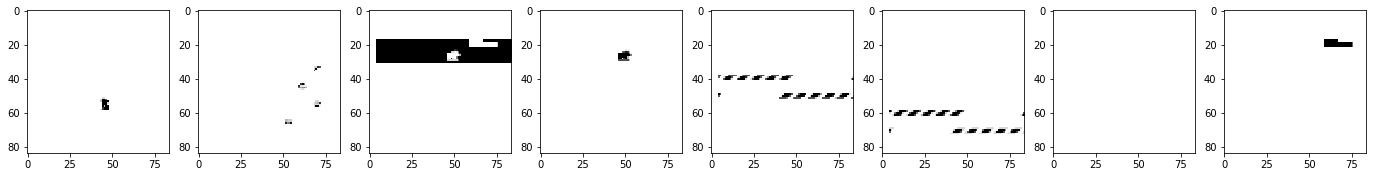

In [25]:
frame_idx = 1100
state = observation_to_model(masks_only_env, sample_full_color_observations[frame_idx]).cpu().numpy()

plt.figure(figsize=(24, 4))
for i in range(state.shape[0]):
    ax = plt.subplot(1, 8, i + 1)
    ax.imshow(state[i], cmap='Greys')
    
plt.show()

In [103]:
DIAGONAL_CONNECTIVITY_STRUCTURE = ndimage.generate_binary_structure(2, 2)


def extract_object(observations, obs_index, model, env, channel_index, 
                   object_index=0, structure=DIAGONAL_CONNECTIVITY_STRUCTURE,
                   return_tensor=True, return_location=False):
    state = observation_to_model(env, observations[obs_index]).cpu().numpy()
    labeled, count = ndimage.label(state[channel_index], structure)
    locations = ndimage.find_objects(labeled, 0)
    print(locations)
    loc = locations[object_index]
    if return_location:
        return loc
    
    object_arr = state[channel_index, loc[0], loc[1]]
    if return_tensor:
        return torch.Tensor(object_arr).to(model.online_net.convs[0].weight.device)
    
    return object_arr
    

[(slice(33, 36, None), slice(67, 72, None)), (slice(43, 47, None), slice(59, 64, None)), (slice(53, 57, None), slice(67, 72, None)), (slice(64, 67, None), slice(51, 55, None))]


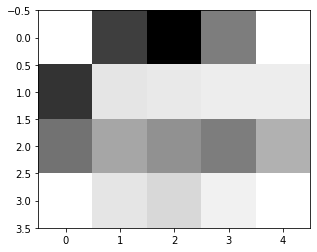

In [106]:
obj = extract_object(sample_full_color_observations, 1100, masks_only_model, masks_only_env, 1, 1, return_tensor=False)
plt.imshow(obj, cmap='Greys')

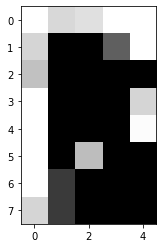

In [47]:


labeled, count = ndimage.label(state[0], structure)
loc = ndimage.find_objects(labeled, 1)[0]
plt.imshow(state[0, loc[0], loc[1]], cmap='Greys')

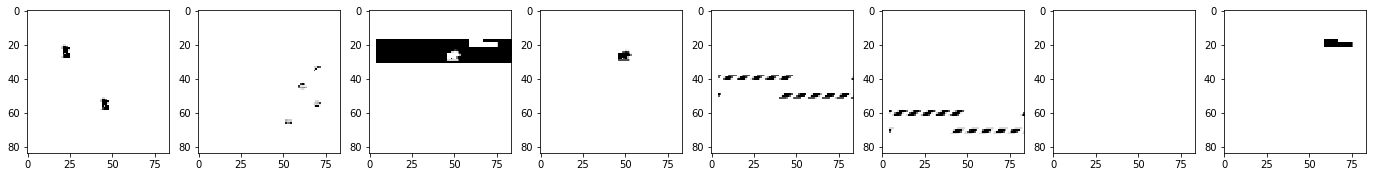

In [48]:
state_copy = np.copy(state)
state_copy = copy_object(state_copy, 0, loc, (20, 20))

plt.figure(figsize=(24, 4))
for i in range(state_copy.shape[0]):
    ax = plt.subplot(1, 8, i + 1)
    ax.imshow(state_copy[i], cmap='Greys')
    
plt.show()

In [66]:
mses = np.array([F.mse_loss(masks_only_model_results.q_values[i], masks_only_model_results.q_values[i].mean()).cpu().numpy() 
        for i in range(len(masks_only_model_results.q_values))])

max_idx = np.argmax(mses)
max_idx, mses[max_idx], masks_only_model_results.q_values[max_idx]

/misc/vlgscratch4/LakeGroup/guy/anaconda3/envs/rainbow/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([18])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  


(1449,
 4.2071524,
 tensor([0.3409, 0.1713, 3.9649, 0.6107, 0.2131, 1.9395, 0.8893, 0.1201, 6.3739,
         0.0257, 0.1518, 0.6802, 0.0329, 3.1184, 0.4893, 0.0332, 6.3191, 0.0286],
        device='cuda:0'))

/misc/vlgscratch4/LakeGroup/guy/anaconda3/envs/rainbow/lib/python3.7/site-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


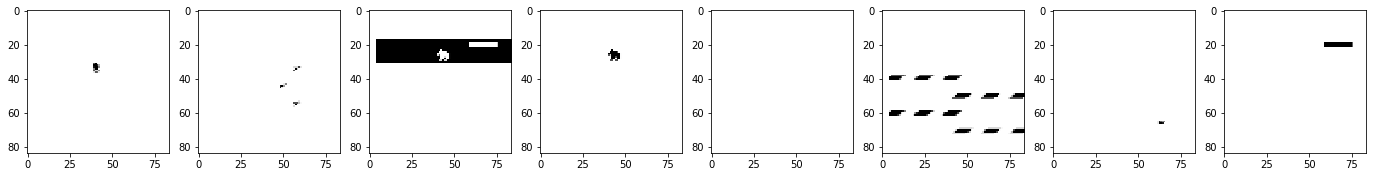

In [67]:
frame_idx = 1449
state = observation_to_model(masks_only_env, sample_full_color_observations[frame_idx]).cpu().numpy()

plt.figure(figsize=(24, 4))
for i in range(state.shape[0]):
    ax = plt.subplot(1, 8, i + 1)
    ax.imshow(state[i], cmap='Greys')
    
plt.show()

In [70]:
object_locations = []

for channel_idx in range(state.shape[0]):
    labeled, count = ndimage.label(state[channel_idx], structure)
    object_locations.append(ndimage.find_objects(labeled))

In [ ]:
def print_model_state_description(state, name, index, top_k=3):
    value = results.state_values[index]
    action = results.actions[index]
    print(f'{name} had value {value:.3f} => {ALE_ACTIONS[action]} ({action})')
    q = results.q_values[index].cpu().numpy()
    top_actions = np.argpartition(q, -top_k)[-top_k:]
    top_actions = top_actions[np.argsort(q[top_actions])][::-1]
    p = F.softmax(results.q_values[index], dim=0)
    print(' | '.join([f'({i + 1}) {ALE_ACTIONS[a]} [{a}], Q = {q[a]:.3f}, P = {p[a]:.3f}' for i, a in enumerate(top_actions)]))

In [76]:
new_player_locations = [(20, 20), (20, 60), (60, 20), (60, 60)]

for i in range(len(new_player_locations)):
    state_copy = np.copy(state)
    for j in range(i + 1):
        state_copy = copy_object(state_copy, 0, object_locations[0][0], new_player_locations[j])
        
    state_tensor = torch.Tensor(state_copy).to(masks_only_model.online_net.convs[0].weight.device)
    
    

AttributeError: 'Agent' object has no attribute 'device'

device(type='cuda', index=0)

# More organized take at this code

In [217]:
ChannelAugmentation = namedtuple('ChannelAugmentation', 
                                 ('channel_index', 'added_object', 'added_location'))

ModelAugmentation = namedtuple('ModelAugmentation', 
                               ('name', 'model', 'env', 'augmentations'))


def augment_single_channel(state, channel_augmentation):
    dst_slices = [slice(channel_augmentation.added_location[i], 
                        channel_augmentation.added_location[i] + channel_augmentation.added_object.shape[i])
                  for i in range(len(channel_augmentation.added_location))] 
    state[channel_augmentation.channel_index, dst_slices[0], dst_slices[1]] = channel_augmentation.added_object
    return state
    

def modify_state(state, augmentations):
    for augmentation in augmentations:
        state = augment_single_channel(state, augmentation)
        
    return state


def augmented_state_q_values(observations, augmented_index, model_augmentations, state_length=4, return_before_and_after=False):
    if augmented_index < state_length or augmented_index >= len(observations):
        raise ValueError(f'Augmented index should be in [{state_length}, {len(observations)}), received {augmented_index}')

    before_q_values_per_model = []
    after_q_values_per_model = []
    before = None, after = None
    
    for model_augmentation in model_augmentations:
        # TODO: verify I don't have an off-by-one here
        state_buffer = [observation_to_model(model_augmentation.env, obs) 
                        for obs in observations[augmented_index - state_length + 1:augmented_index + 1]]
        
        if return_before_and_after and before is None:
            before = state_buffer[-1][0].cpu().numpy()
        model_ready_state = torch.cat(list(state_buffer), 0)
        before_q_values_per_model.append(model_augmentation.model.expected_q_values(model_ready_state))

        augmented_state = modify_state(state_buffer[-1], model_augmentation.augmentations)
        if return_before_and_after and after is None:
            after = state_buffer[-1][0].cpu().numpy()
            
        # TODO: consider the case of augmenting more than one consecutive states
        state_buffer[-1] = augmented_state
        model_ready_state = torch.cat(list(state_buffer), 0)
        # TODO: grab action values or state values if need be
        after_q_values_per_model.append(model_augmentation.model.expected_q_values(model_ready_state))

    if return_before_and_after:
        return before_q_values_per_model, after_q_values_per_model, before, after
    
    return before_q_values_per_model, after_q_values_per_model


def max_wrapper(tensor, axis=0):
    val, idx = tensor.max(axis)
    return float(val), int(idx)


def evaluate_augmented_models(observations, augmented_index, model_augmentations, state_length=4,
                              before_color='red', after_color='blue', bar_alpha=0.5,
                              bar_width=0.8, fontdict=dict(fontsize=16), force_text=None, text_epsilon=0,
                              plot_state=True):
    if plot_state:
        fig = plt.figure(constrained_layout=True, figsize=(8 * len(model_augmentations + 1), 6))
        gs = fig.add_gridspec(1, 8)
        before_q_values_per_model, after_q_values_per_model, before_state, after_state =\ 
            augmented_state_q_values(observations, augmented_index, 
                                     model_augmentations, state_length=state_length, return_before_and_after=True)

        before_ax = fig.add_subplot(gs[:, 0])
        before_ax.imshow(before_state)
        before_ax.set_title('Before')
        
        after_ax = fig.add_subplot(gs[:, 1])
        after_ax.imshow(after_state)
        after_ax.set_title('After')
    
    else:
        plt.figure(figsize=(8 * len(model_augmentations), 6))
        before_q_values_per_model, after_q_values_per_model = augmented_state_q_values(observations, augmented_index, 
                                                                                       model_augmentations, state_length=state_length)

    

    for i, (model_augmentation, before_q, after_q) in enumerate(zip(model_augmentations, before_q_values_per_model,
                                                                          after_q_values_per_model)):
        print(f'For model {model_augmentation.name}:')
        baseline_mean, augmented_mean = before_q.mean().cpu().numpy(), after_q.mean().cpu().numpy()
        print(f'Baseline mean: {baseline_mean:.3f}, Augmented mean: {augmented_mean:.3f}, Difference: {augmented_mean - baseline_mean:.3f}')
        diff = after_q - before_q
        max_diff, max_diff_idx = max_wrapper(diff)
        print(f'Max Q value diff is {max_diff:.3f} for action {ALE_ACTIONS[max_diff_idx]} [{max_diff_idx}]')

        if plot_state:
            ax = fig.add_subplot(gs[:, 2 * (i + 1):2 * (i + 2)])
        else:
            ax = plt.subplot(1, len(model_augmentations), i + 1)
        
        locations = np.arange(before_q.shape[0]) * bar_width * 2.5
        ax.bar(locations, before_q.cpu().numpy(), color=before_color, alpha=bar_alpha)
        ax.bar(locations + bar_width, after_q.cpu().numpy(), color=after_color, alpha=bar_alpha)
        ax.hlines([baseline_mean, augmented_mean], *ax.get_xlim(), colors=[before_color, after_color],
                  linestyles='dashed')
        
        text_fd = {k:fontdict[k] for k in fontdict}
        ax.text(locations[max_diff_idx], max(before_q[max_diff_idx], after_q[max_diff_idx]) + text_epsilon,
                '*', fontdict=text_fd)
        
        before_action_q, before_action_idx = max_wrapper(before_q)
        after_action_q, after_action_idx = max_wrapper(after_q)
        
        if before_action_idx != after_action_idx or (force_text is not None and force_text):
            text_fd['color'] = before_color
            ax.text(locations[before_action_idx] - (bar_width / 2), before_action_q + text_epsilon, 'B', fontdict=text_fd)

            text_fd['color'] = after_color
            ax.text(locations[after_action_idx] + (bar_width / 2), after_action_q + text_epsilon, 'A', fontdict=text_fd)
        
        ax.set_xlabel('Action Index', fontdict=fontdict)
        ax.set_ylabel('Q Value', fontdict=fontdict)
        ax.set_title(model_augmentation.name, fontdict=fontdict)

    plt.show()


def evaluate_augmented_models_multiple_XXX(*args):
    # TODO: if using multiple states or models, we need to average properly over the before_q / after_q tensors
    # That is, compute the average mean difference and the average max difference
    # The per-action bar charts might make less sense?
    # If we do this, we can plot a histogram of MMeanD and MMaxD and over the different random seeds (for one state)
    # Or the different states for one (or more) random seeds
    pass





SyntaxError: unexpected character after line continuation character (<ipython-input-217-d895782a744e>, line 69)

In [200]:
DIAGONAL_CONNECTIVITY_STRUCTURE = ndimage.generate_binary_structure(2, 2)


def to_tensor(numpy_arr, model):
    return torch.Tensor(numpy_arr).to(model.online_net.convs[0].weight.device)


def extract_raw_pixels_object(observations, obs_index, model, env, loc):
    model_ready_obs = to_tensor(observation_to_model(env, observations[obs_index]).cpu().numpy(), model)
    return model_ready_obs.squeeze()[loc]


def extract_object(observations, obs_index, model, env, channel_index, 
                   object_index=0, structure=DIAGONAL_CONNECTIVITY_STRUCTURE,
                   return_tensor=True, return_location=False):
    state = observation_to_model(env, observations[obs_index]).cpu().numpy()
    labeled, count = ndimage.label(state[channel_index], structure)
    locations = ndimage.find_objects(labeled, 0)
    loc = locations[object_index]
    
    object_arr = state[channel_index, loc[0], loc[1]]
    if return_tensor:
        object_arr = to_tensor(object_arr, model)
        
    if not return_location:
        return object_arr
    
    return object_arr, loc
    

def copy_model_augmentation(model_augmentation, channel_augmentations):
    return ModelAugmentation(model_augmentation.name, model_augmentation.model, model_augmentation.env, channel_augmentations)


def make_augmentations_all_models(b_aug, m_p_aug, m_o_aug, pixels_tensor, mask_tensor, mask_only_channel_index, locations):
    baseline_augs = [ChannelAugmentation(0, pixels_tensor, loc) for loc in locations]
    mask_only_augs = [ChannelAugmentation(mask_only_channel_index, mask_tensor, loc) for loc in locations]
    maks_and_pixels_augs = baseline_augs[:]
    maks_and_pixels_augs.extend([ChannelAugmentation(c_a.channel_index + 1, c_a.added_object, c_a.added_location)
                                  for c_a in mask_only_augs])
    
    return copy_model_augmentation(b_aug, baseline_augs), copy_model_augmentation(m_p_aug, maks_and_pixels_augs),\
        copy_model_augmentation(m_o_aug, mask_only_augs)
    
    return b_aug, m_p_aug, m_o_aug
    
    

# A.0 Setup

In [144]:
baseline_run = api.run('augmented-frostbite/initial-experiments/runs/fdxobftk')
baseline_model, baseline_env = load_model_from_run(baseline_run)
# baseline_model_results = pass_states_through_model(baseline_model, baseline_env, sample_full_color_observations, skip=1)

masks_and_pixels_run = api.run('augmented-frostbite/masks-and-pixels-replication/runs/grh1bzvv')
masks_and_pixels_model, masks_and_pixels_env = load_model_from_run(masks_and_pixels_run)
# masks_and_pixels_model_results = pass_states_through_model(masks_and_pixels_model, masks_and_pixels_env, sample_full_color_observations, skip=1)

masks_only_run = api.run('augmented-frostbite/masks-only-replication/runs/0khc2n2c')
masks_only_model, masks_only_env = load_model_from_run(masks_only_run)
# masks_only_model_results = pass_states_through_model(masks_only_model, masks_only_env, sample_full_color_observations, skip=1)

baseline_aug_template = ModelAugmentation('Baseline', baseline_model, baseline_env, list())
masks_and_pixels_aug_template = ModelAugmentation('Masks+Pixels', masks_and_pixels_model, masks_and_pixels_env, list())
masks_only_aug_template = ModelAugmentation('Masks-Only', masks_only_model, masks_only_env, list())

# A.1 Additional player

In [213]:
OBS_INDEX = 1449

player_mask_tensor, player_loc = extract_object(sample_full_color_observations, OBS_INDEX, masks_only_model, masks_only_env,
                                           channel_index=0, object_index=0, return_location=True)
player_pixels_tensor = extract_raw_pixels_object(sample_full_color_observations, OBS_INDEX, baseline_model, baseline_env, player_loc)

NEW_PLAYER_LOCATION = (30, 30)

baseline_player_aug, masks_and_pixels_player_aug, masks_only_player_aug =\
    make_augmentations_all_models(baseline_aug_template, masks_and_pixels_aug_template, masks_only_aug_template,
                                  player_pixels_tensor, player_mask_tensor, 0, [NEW_PLAYER_LOCATION])

For model Baseline:
Baseline mean: 4.134, Augmented mean: 3.573, Difference: -0.562
Max Q value diff is -0.184 for action left + fire [12]
For model Masks+Pixels:
Baseline mean: 2.892, Augmented mean: 2.380, Difference: -0.513
Max Q value diff is -0.313 for action left [4]
For model Masks-Only:
Baseline mean: 4.474, Augmented mean: 2.739, Difference: -1.735
Max Q value diff is -0.839 for action down + right [8]


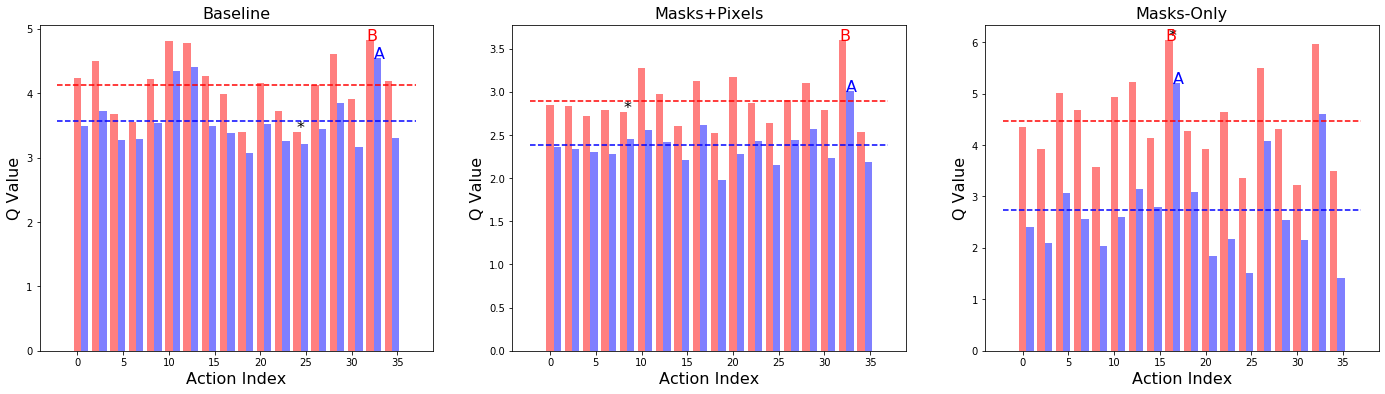

In [216]:
evaluate_augmented_models(sample_full_color_observations, OBS_INDEX, 
                         [baseline_player_aug, masks_and_pixels_player_aug, masks_only_player_aug],
                          force_text=True)
    

In [181]:
float(t[0, 0])

1.0